# pandas实现groupby分组统计

类似SQL:
select city, max(temperature) from city_weather group by city;

groupby: 先对数据分组, 然后在每个分组上应用聚合函数、转换函数

本次示例:
1. 分组使用聚合函数做数据统计
2. 遍历groupby的结果理解执行流程
3. 实例分组探索天气数据

In [1]:
import pandas as pd
import numpy as np
from pylab import mpl
from pandas import DataFrame
# 加上这一句, 能在jupyter notebook展示matplot图表
%matplotlib inline

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
df = pd.DataFrame({'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
                   'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
                   'C': np.random.randn(8),
                   'D': np.random.randn(8)})
df

,A,B,C,D
0,foo,one,0.051180,0.037059
1,bar,one,0.247776,-0.395085
2,foo,two,0.005444,0.376951
3,bar,three,1.561245,-0.941800
4,foo,two,1.247183,-0.428137
5,bar,two,-1.138623,-1.958596
6,foo,one,-1.538705,0.353674
7,foo,three,0.848272,-0.577915


## 一. 分组使用聚合函数做数据统计
**1.单个列groupby, 查询所有数据列的统计**

In [3]:
df.groupby('A').sum()

,B,C,D
A,,,
bar,onethreetwo,0.670398,-3.295481
foo,onetwotwoonethree,0.613374,-0.238368


**2.多个列groupby, 查询所有数据列的统计**

In [4]:
df.groupby(['A', 'B']).mean()

C         D
A   B                        
bar one    0.247776 -0.395085
    three  1.561245 -0.941800
    two   -1.138623 -1.958596
foo one   -0.743763  0.195366
    three  0.848272 -0.577915
    two    0.626314 -0.025593

我们看到('A', 'B')成对变成了二级索引

In [5]:
df.groupby(['A', 'B'], as_index=False).mean()

,A,B,C,D
0,bar,one,0.247776,-0.395085
1,bar,three,1.561245,-0.941800
2,bar,two,-1.138623,-1.958596
3,foo,one,-0.743763,0.195366
4,foo,three,0.848272,-0.577915
5,foo,two,0.626314,-0.025593


**3.同时查看多种数据统计**

In [6]:
exclude_b_df = df.loc[:, df.columns != 'B']
exclude_b_df.groupby('A').agg([np.sum, np.mean, np.std])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar  0.670398  0.223466  1.350098 -3.295481 -1.098494  0.793446
foo  0.613374  0.122675  1.068884 -0.238368 -0.047674  0.440021

我们看到: 列变成了多级索引

**4.查看单列的结果数据统计**

In [7]:
# 方法1: 预过滤, 性能更好
exclude_b_df.groupby('A')['C'].agg([np.sum, np.mean, np.std])

,sum,mean,std
A,,,
bar,0.670398,0.223466,1.350098
foo,0.613374,0.122675,1.068884


In [8]:
# 方法2
exclude_b_df.groupby('A').agg([np.sum, np.mean, np.std])['C']

,sum,mean,std
A,,,
bar,0.670398,0.223466,1.350098
foo,0.613374,0.122675,1.068884


**5.不同列使用不同的聚合函数**

In [9]:
exclude_b_df.groupby('A').agg({'C': np.sum, 'D': [np.mean, np.std]})

C         D          
          sum      mean       std
A                                
bar  0.670398 -1.098494  0.793446
foo  0.613374 -0.047674  0.440021

## 二.遍历groupby的结果理解执行流程
for 循环可以直接遍历每个group

**1.遍历单个聚合的分组**

In [10]:
g = exclude_b_df.groupby('A')
g

In [11]:
for name, group in g:
    print(name)
    print(group)
    print()

bar
     A         C         D
1  bar  0.247776 -0.395085
3  bar  1.561245 -0.941800
5  bar -1.138623 -1.958596

foo
     A         C         D
0  foo  0.051180  0.037059
2  foo  0.005444  0.376951
4  foo  1.247183 -0.428137
6  foo -1.538705  0.353674
7  foo  0.848272 -0.577915



**可以获取单个返祖的数据**

In [12]:
g.get_group('bar')

,A,C,D
1,bar,0.247776,-0.395085
3,bar,1.561245,-0.941800
5,bar,-1.138623,-1.958596


**2遍历多个聚合的分组**

In [13]:
g1 = df.groupby(['A', 'B'])

In [14]:
for name, group in g1:
    print(name)
    print(group)
    print()

('bar', 'one')
     A    B         C         D
1  bar  one  0.247776 -0.395085

('bar', 'three')
     A      B         C       D
3  bar  three  1.561245 -0.9418

('bar', 'two')
     A    B         C         D
5  bar  two -1.138623 -1.958596

('foo', 'one')
     A    B         C         D
0  foo  one  0.051180  0.037059
6  foo  one -1.538705  0.353674

('foo', 'three')
     A      B         C         D
7  foo  three  0.848272 -0.577915

('foo', 'two')
     A    B         C         D
2  foo  two  0.005444  0.376951
4  foo  two  1.247183 -0.428137



可以看到, name是一个2个元素的tuple, 代表不同的列

In [15]:
g1.get_group(('foo', 'one'))

,A,B,C,D
0,foo,one,0.051180,0.037059
6,foo,one,-1.538705,0.353674


**可以直接查询group后的某几列, 生成Series或者子DataFrame**

In [16]:
g1['C']

In [17]:
for name, group in g1['C']:
    print(name)
    print(group)
    print(type(group))
    print()

('bar', 'one')
1    0.247776
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'three')
3    1.561245
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'two')
5   -1.138623
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'one')
0    0.051180
6   -1.538705
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'three')
7    0.848272
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'two')
2    0.005444
4    1.247183
Name: C, dtype: float64
<class 'pandas.core.series.Series'>



其实所有的聚合统计, 都是在DataFrame和Series上进行的

## 三. 实例分组探索天气数据

In [18]:
df_weather = pd.read_excel('./data/weather/weater_beijing.xlsx')
df_weather.loc[:, '最高温'] = df_weather['最高温'].str.replace('°', '').replace('', '0')
df_weather['最高温'].fillna('0', inplace=True)
df_weather.loc[:, '最高温'] = df_weather['最高温'].astype('int32')

In [19]:
df_weather

,日期,最高温,最低温,天气,风力风向,空气质量指数
0,2011-01-01 周六,-2,-7°,多云~阴,无持续风向微风,NaN
1,2011-01-02 周日,-2,-7°,多云,无持续风向微风,NaN
2,2011-01-03 周一,-2,-6°,多云~阴,西北风~北风3-4级~4-5级,NaN
3,2011-01-04 周二,-2,-9°,晴,北风5-6级,NaN
4,2011-01-05 周三,-2,-10°,晴,北风~无持续风向3-4级~微风,NaN
...,...,...,...,...,...,...
4001,2021-12-27 周一,6,-8°,晴,西北风1级,56 良
4002,2021-12-28 周二,6,-5°,多云~晴,西北风1级,64 良
4003,2021-12-29 周三,5,-5°,晴,西北风3级,43 优
4004,2021-12-30 周四,6,-7°,晴,西北风3级,38 优


In [20]:
df_weather.loc[:, '最低温'] = df_weather['最低温'].str.replace('°', '').replace('', '0')
df_weather.fillna({'最低温': '0'}, inplace=True)
df_weather.loc[:, '最低温'] = df_weather['最低温'].astype('int32')

In [21]:
df_weather

,日期,最高温,最低温,天气,风力风向,空气质量指数
0,2011-01-01 周六,-2,-7,多云~阴,无持续风向微风,NaN
1,2011-01-02 周日,-2,-7,多云,无持续风向微风,NaN
2,2011-01-03 周一,-2,-6,多云~阴,西北风~北风3-4级~4-5级,NaN
3,2011-01-04 周二,-2,-9,晴,北风5-6级,NaN
4,2011-01-05 周三,-2,-10,晴,北风~无持续风向3-4级~微风,NaN
...,...,...,...,...,...,...
4001,2021-12-27 周一,6,-8,晴,西北风1级,56 良
4002,2021-12-28 周二,6,-5,多云~晴,西北风1级,64 良
4003,2021-12-29 周三,5,-5,晴,西北风3级,43 优
4004,2021-12-30 周四,6,-7,晴,西北风3级,38 优


In [22]:
df_weather.fillna({'空气质量指数': '未统计'}, inplace=True)
df_weather.loc[:, '空气质量指数'] = df_weather['空气质量指数'].str.split(' ')

air_quality = []
air_quality_index = []


def split_air(d):
    if len(d) > 1:
        air_quality.append(int(d[0]))
        air_quality_index.append(d[1])
    else:
        air_quality.append(-1)
        air_quality_index.append(d[0])


df_weather['空气质量指数'].apply(split_air)
df_weather.loc[:, '空气质量指数'] = air_quality
df_weather.loc[:, '空气质量'] = air_quality_index

In [23]:
df_weather

,日期,最高温,最低温,天气,风力风向,空气质量指数,空气质量
0,2011-01-01 周六,-2,-7,多云~阴,无持续风向微风,-1,未统计
1,2011-01-02 周日,-2,-7,多云,无持续风向微风,-1,未统计
2,2011-01-03 周一,-2,-6,多云~阴,西北风~北风3-4级~4-5级,-1,未统计
3,2011-01-04 周二,-2,-9,晴,北风5-6级,-1,未统计
4,2011-01-05 周三,-2,-10,晴,北风~无持续风向3-4级~微风,-1,未统计
...,...,...,...,...,...,...,...
4001,2021-12-27 周一,6,-8,晴,西北风1级,56,良
4002,2021-12-28 周二,6,-5,多云~晴,西北风1级,64,良
4003,2021-12-29 周三,5,-5,晴,西北风3级,43,优
4004,2021-12-30 周四,6,-7,晴,西北风3级,38,优


In [24]:
# 新增一列月份
df_weather['月份'] = df_weather['日期'].str[:7]

In [25]:
df_weather

,日期,最高温,最低温,天气,风力风向,空气质量指数,空气质量,月份
0,2011-01-01 周六,-2,-7,多云~阴,无持续风向微风,-1,未统计,2011-01
1,2011-01-02 周日,-2,-7,多云,无持续风向微风,-1,未统计,2011-01
2,2011-01-03 周一,-2,-6,多云~阴,西北风~北风3-4级~4-5级,-1,未统计,2011-01
3,2011-01-04 周二,-2,-9,晴,北风5-6级,-1,未统计,2011-01
4,2011-01-05 周三,-2,-10,晴,北风~无持续风向3-4级~微风,-1,未统计,2011-01
...,...,...,...,...,...,...,...,...
4001,2021-12-27 周一,6,-8,晴,西北风1级,56,良,2021-12
4002,2021-12-28 周二,6,-5,多云~晴,西北风1级,64,良,2021-12
4003,2021-12-29 周三,5,-5,晴,西北风3级,43,优,2021-12
4004,2021-12-30 周四,6,-7,晴,西北风3级,38,优,2021-12


**1.查看每个月的最高温**

In [26]:
data = df_weather.groupby('月份')['最高温'].max()
data

月份
2011-01     7
2011-02    11
2011-03    22
2011-04    28
2011-05    33
           ..
2021-08    33
2021-09    31
2021-10    23
2021-11    18
2021-12    13
Name: 最高温, Length: 132, dtype: object

In [27]:
type(data)

pandas.core.series.Series

<Axes: xlabel='月份'>

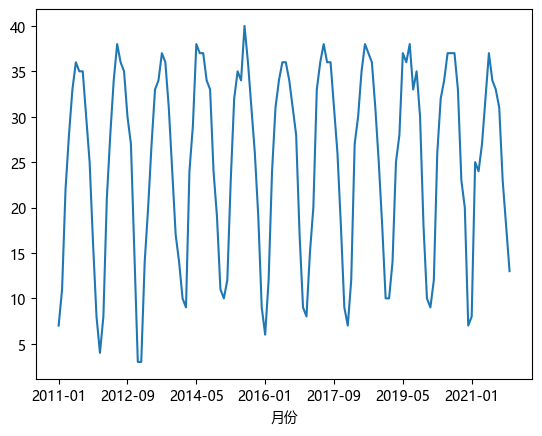

In [28]:
data.plot()

**2.查看每个月的最高温、最低温、平均空气质量指数**

In [29]:
data1 = df_weather.groupby('月份').agg({'最高温': np.max, '最低温': np.min, '空气质量指数': np.mean})
data1

,最高温,最低温,空气质量指数
月份,,,
2011-01,7,-10,-1.0
2011-02,11,-10,-1.0
2011-03,22,-4,-1.0
2011-04,28,1,-1.0
2011-05,33,11,-1.0
...,...,...,...
2021-08,33,17,40.580645
2021-09,31,14,41.366667
2021-10,23,1,52.645161


<Axes: xlabel='月份'>

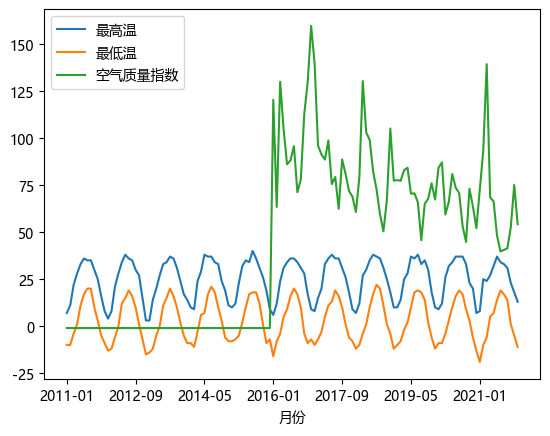

In [32]:
data1.plot()